<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/feature%2Freconhecimento-texto/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Instalações e importações

## 1.1 Bibliotecas

In [ ]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

In [24]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

In [5]:
!mkdir tessdata

In [6]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-08-29 23:57:05--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-08-29 23:57:05--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-08-29 23:57:05--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

## 1.2 Imagens

In [30]:
artigo = 'imagens/artigo.png'
codigo = 'imagens/codigo.png'
nota_fiscal = 'imagens/nota_fiscal.png'
pagina = 'imagens/pagina.jpg'

# 2 Tratamento de imagens

In [8]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [9]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [34]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

# 3 Detecção e extração de textos

In [11]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [102]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        # 'es': 'spa',
        # 'fr': 'fra',
        # 'id': 'ind',
        # 'it': 'ita',
        # 'ja': 'jpn',
        'pt': 'por',
        # 'th': 'tha',
        # 'uk': 'ukr',
        # 'zh-cn': 'chi_sim',
        # 'zh-tw': 'chi_tra'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

In [72]:
import imutils

In [121]:
def orient_vertical(img):
    # Usa a transformada de Hough para detectar linhas
    lines = cv2.HoughLines(img, 1, np.pi/180, 200)

    # Se nenhuma linha foi encontrada, retorne a imagem original
    if lines is None:
        return img

    # Calcule o ângulo médio das linhas encontradas
    angles = []
    for rho, theta in lines[:, 0]:
        angle = (np.degrees(theta) - 90) % 180 - 90  # Faixa de -90 a 90
        angles.append(angle)

    # Calcula o ângulo médio
    mean_angle = np.mean(angles)

    # Se a inclinação for muito drástica (quase 90 graus), ajusta o ângulo
    # if 45 <= mean_angle <= 90:
    #     mean_angle -= 90
    # elif -45 >= mean_angle >= -90:
    #     mean_angle += 90

    # Rotaciona a imagem para corrigir a inclinação
    rotated = imutils.rotate_bound(img, 360 + 10)
    return rotated

In [150]:
def extrair_texto(imagem):

    imagem = cv2.imread(imagem)
    imagem = realcar_detalhes(imagem)
    imagem = ajustar_brilho(imagem)
    img_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    img_binarizada = binarizar(img_cinza)

    psm_valor = determinar_psm(img_binarizada)
    cod_idioma = detectar_idioma(img_binarizada)

    resultado = pt.image_to_data(img_binarizada,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return img_binarizada, texto

# 4 Testes de OCR

In [15]:
min_conf = 40 #@param {type: 'slider', min:0,max: 100}

## 4.1 Trecho de artigo

In [ ]:
imagem, texto = extrair_texto(artigo)
cv2_imshow(imagem)
print(texto)

## 4.2 Trecho de código do Visual Studio Code

In [ ]:
imagem, texto = extrair_texto(codigo)
cv2_imshow(imagem)
print(texto)

## 4.3 Nota fiscal

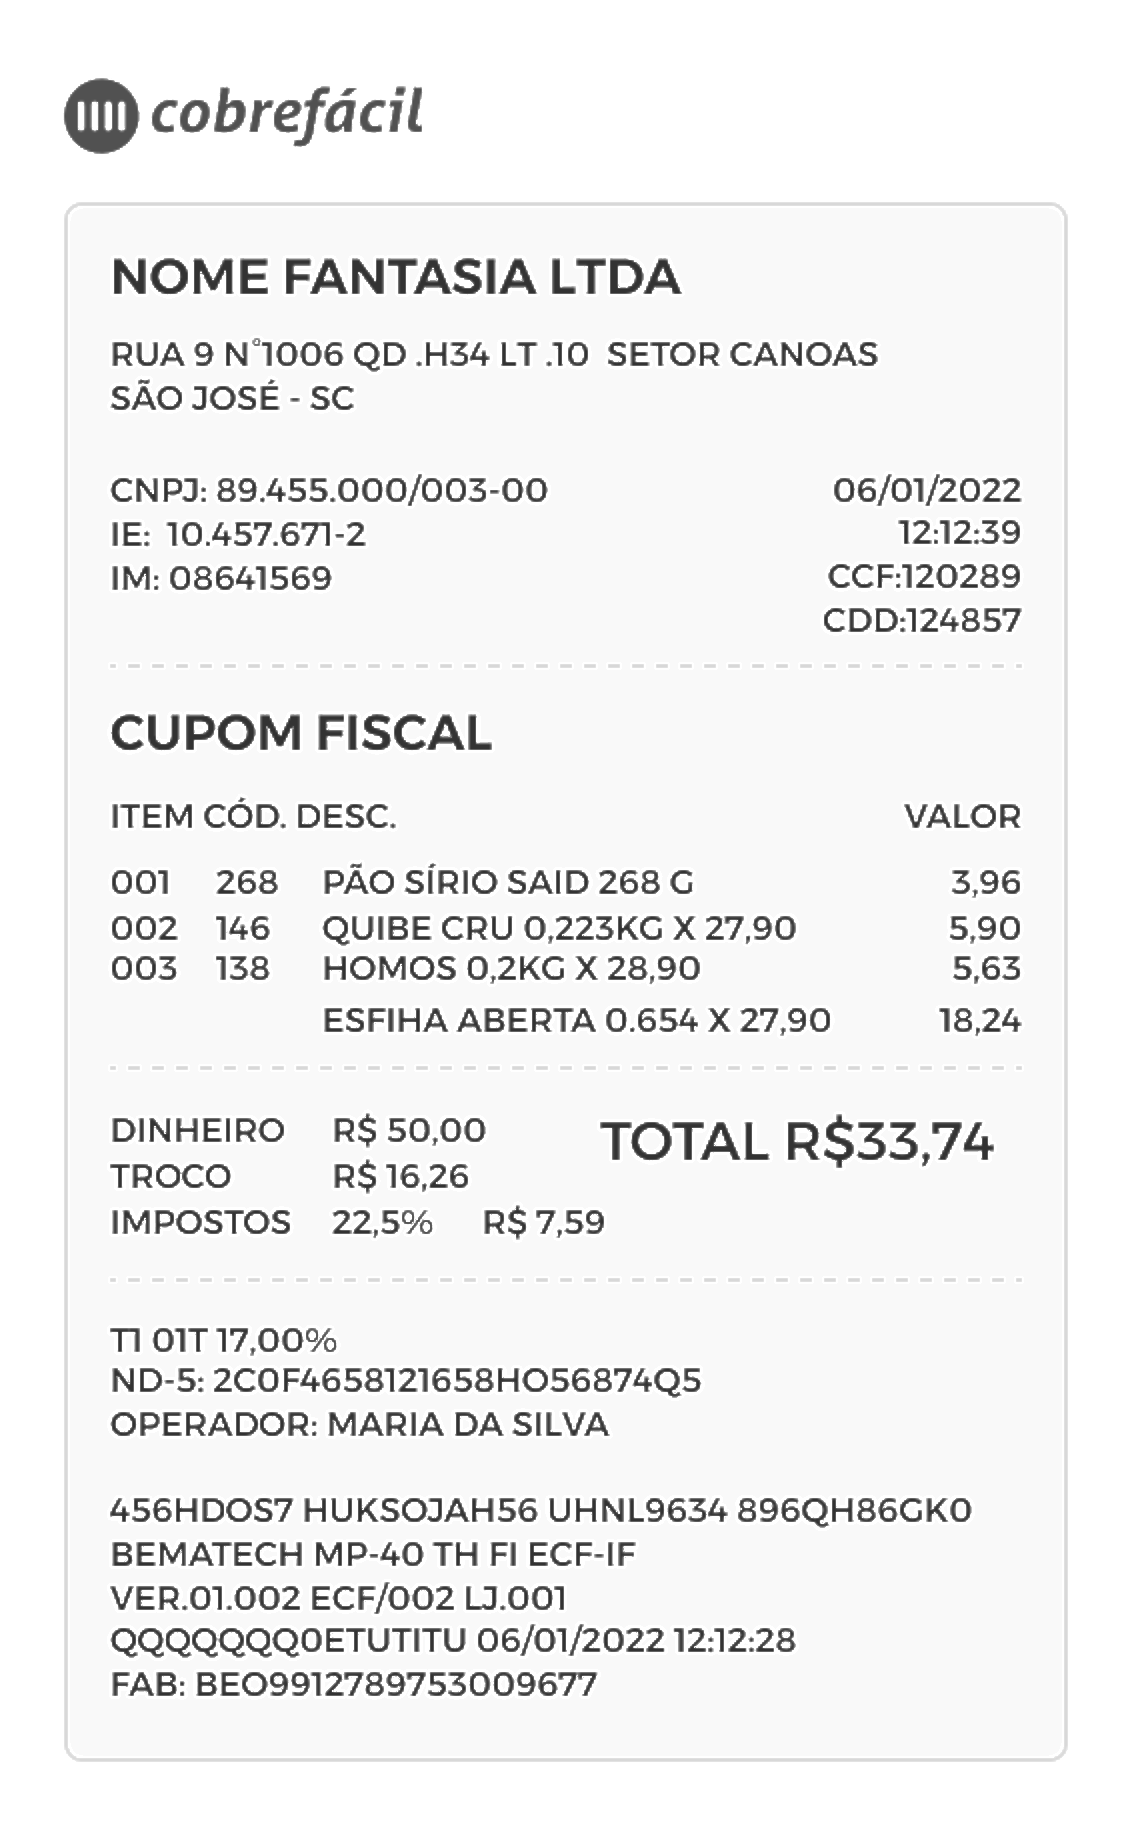

@ NOME FANTASIA LTDA RUA 9 QD .H34 LT .10 SETOR CANOAS SAO JOSE - SC CNP3J: 89.455.000/003-00 06/01/2022 IE: 10.457.671-2 12:12:39 IM: 08641569 CCF:120289 CDD:124857 CUPOM FISCAL ITEM COD. DESC. VALOR 001 268 PAO SIRIO SAID 268G 3,96 002 146 QUIBE CRU 0,223KG X 27,90 5,90 003 138 HOMOS 0,2KG X 28,90 5,63 ESFIHA ABERTA 0.654 X 27,90 18,24 DINHEIRO R$ 50,00 TOTAL R$33,74 TROCO R$ 16,26 IMPOSTOS 225% R$759 T1 01T 17,00% ND-5: 2COF4658121658HO56874Q5 OPERADOR: MARIA DA SILVA 456HDOS7 HUKSOJAH56 UHNL9634 BEMATECH MP-40 TH ECF-IF VER.01.002 ECF/002 L3.001 QQQQQQQOETUTITU 06/01/2022 12:12:28 FAB: BEO9912789753009677


In [91]:
imagem, texto = extrair_texto(nota_fiscal)
cv2_imshow(imagem)
print(texto)

## 4.4 Página de um livro

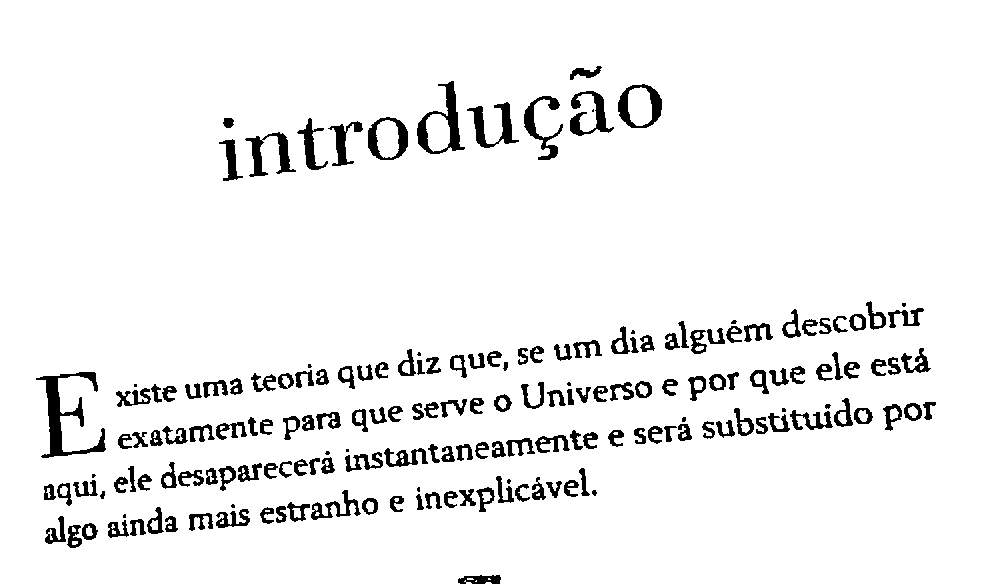

introdução se um dia alguém descobrir o Universo € que ele está bstituido por ecerà instantaneamente e será Su aqui, ele desapar stranho e inexplicável. algo sinda mais €


In [153]:
imagem, texto = extrair_texto(pagina)
cv2_imshow(imagem)
print(texto)